In [1]:
import models.utils
import random, gc, os, pickle, csv, time, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Find all epoch of CSV

In [2]:
# SEQ
BASE_MODEL_PATH = "/data/model_runs/original_oml/aSEQ-order1"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aSEQ-order2"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aSEQ-order3"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aSEQ-order4"

# REP
BASE_MODEL_PATH = "/data/model_runs/original_oml/aREP-order1"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aREP-order2"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aREP-order3"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aREP-order4"

# OML
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order1-ori"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order2-ori"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order3-ori"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order4-ori"
# OML with more beautiful MAMLviz
BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31"

# MELSTA
BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order1-2023-03-15-no12"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order2-2023-03-14-no12"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order3-2023-03-14-no12"
BASE_MODEL_PATH = "/data/model_runs/original_oml/aOML-order4-2023-03-13-no12"
# MeLSTA Ablation
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-noadaptscore"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-noadaptscore-order2"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-noadaptscore-order3"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-noadaptscore-order4"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nosr"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nosr-order2"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nosr-order3"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nosr-order4"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nocurrireplay"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nocurrireplay-order2"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nocurrireplay-order3"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-nocurrireplay-order4"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-dssplit"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-dssplit-order2"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-dssplit-order3"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-dssplit-order4"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-allquery"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-allquery-order2"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-allquery-order3"
# BASE_MODEL_PATH = "/data/model_runs/original_oml/aMEL-allquery-order4"



order = int(BASE_MODEL_PATH.split("order")[-1][0]) if "order" in BASE_MODEL_PATH else 1
update = 5
# find_path = ""
find_path = f"update{update}" # For MeLSTA! / Anything that needs updates
csv_names = [x for x in os.listdir(BASE_MODEL_PATH) if  re.search(f"id.*{find_path}.*results.*\.csv$", x)]
csv_paths = sorted([os.path.join(BASE_MODEL_PATH, csv_name) for csv_name in csv_names])
print(f"This is running at order {order}")
print(f"Using csv from {csv_paths}")

This is running at order 4
Using csv from ['/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id0-2023-03-12_20-12-03.549134_update5_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id1-2023-03-12_21-46-47.982146_update5_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id2-2023-03-12_23-19-49.310972_update5_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id3-2023-03-13_00-55-52.412861_update5_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id4-2023-03-13_02-29-39.653929_update5_results.csv']


# Get Label Dict and Pred Dict

In [3]:
def process_data(csv_path):
    # Map of dataset -> Array<number>
    label_dict, pred_dict = {}, {}
    label_conf_dict = {}
    with open(csv_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
                continue
            #print(row)

            dataset = ''.join([i for i in row[0] if not i.isdigit()]) # Remove all numbers to get dataset
            label = int(row[1])
            pred = int(row[3])
            label_conf = float(row[2])

            label_dict[dataset] = label_dict.get(dataset, []) + [label]
            pred_dict[dataset]  = pred_dict.get(dataset, []) + [pred]
            label_conf_dict[dataset] = label_conf_dict.get(dataset, []) + [label_conf]

            line_count += 1
    return label_dict, pred_dict, label_conf_dict

# Craft Result Dict

```json
{
    "basePath": "/data/model_runs/original_oml/aOML-order1-2023-03-15-no12",
    "csvPaths": ['/data/model_runs/original_oml/aOML-order1-2023-03-15-no12/OML-order1-id0-2023-03-15_08-13-48.008127_update5_results.csv', ..., '/data/model_runs/original_oml/aOML-order1-2023-03-15-no12/OML-order1-id4-2023-03-15_14-27-32.837449_update5_results.csv'],
    "dataKeys": ['YelpDataset', 'AGNewsDataset', 'DBPediaDataset', 'AmazonDataset', 'YahooAnswersDataset'],
    "acc": [[0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0], ..., [0.6535526315789474, 0.9057894736842105, 0.9886842105263158, 0.6177631578947368, 0.7728947368421053]],
    "prec": [[0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0], ..., [0.6535526315789474, 0.9057894736842105, 0.9886842105263158, 0.6177631578947368, 0.7728947368421053]],
    "rec": [[0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0], ..., [0.6535526315789474, 0.9057894736842105, 0.9886842105263158, 0.6177631578947368, 0.7728947368421053]],
    "f1": [[0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0], ..., [0.6535526315789474, 0.9057894736842105, 0.9886842105263158, 0.6177631578947368, 0.7728947368421053]],
    // Related to Overall Performance
    "aa": [0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0],
    "af1": [0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0],
    "aia": [0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0],
    // Related to Memory Stability
    "forgetting": [[0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0], ..., [0.6535526315789474, 0.9057894736842105, 0.9886842105263158, 0.6177631578947368, 0.7728947368421053]],
    "fm": [0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0],
    // Related to Learning Plasticity
    // ** Need Partial Joint Model
    "im": [0.6819736842105263, 0.0, 0.0, 0.6002631578947368, 0.0],
}
```

In [4]:
tasks = [
    ['YelpDataset', 'AGNewsDataset', 'DBPediaDataset', 'AmazonDataset', 'YahooAnswersDataset'],
    ['DBPediaDataset', 'YahooAnswersDataset', 'AGNewsDataset', 'AmazonDataset', 'YelpDataset'],
    ['YelpDataset', 'YahooAnswersDataset', 'AmazonDataset', 'DBPediaDataset', 'AGNewsDataset'],
    ['AGNewsDataset', 'YelpDataset',  'AmazonDataset', 'YahooAnswersDataset', 'DBPediaDataset'],
]

In [5]:
acc, prec, rec, f1 = [], [], [], []
aa, af1, aia = [], [], []
forgetting, fm = [], []
label_conf = []

for i, csv_path in enumerate(csv_paths):
    print(f"Processing data in {csv_path}")
    label_dict, pred_dict, label_conf_dict = process_data(csv_path)

    #keys = list(label_dict.keys()) # This is not correct since each order is tested on order 1 seq!
    keys = tasks[order-1]
    print(keys)

    for key in keys:
        _acc, _prec, _rec, _f1 = models.utils.calculate_metrics(pred_dict[key], label_dict[key])
        acc[i].append(_acc) if i < len(acc) else acc.append([_acc])
        prec[i].append(_prec) if i < len(prec) else prec.append([_prec])
        rec[i].append(_rec) if i < len(rec) else rec.append([_rec])
        f1[i].append(_f1) if i < len(f1) else f1.append([_f1])
        label_conf[i].append(label_conf_dict[key]) if i < len(label_conf) else label_conf.append([label_conf_dict[key]])
    print(acc[i])
    
    # Average Accuracy - is mean of latest populated acc
    # Average F1 - is mean of latest populated f1
    # Average Incremental Accuracy - is mean of AA
    aa.append(np.mean(acc[i][:i+1])) # Only AA of the current task!
    af1.append(np.mean(f1[i][:i+1]))
    aia.append(np.mean(aa)) 
    
    # Forgetting - max past performance - curr performance
    # limited to only learnt tasks!! 
    max_perf = [0]*len(keys) if i == 0 else np.max(np.array(acc[:-1]), axis=0)
    forget = [0]*len(keys) if i == 0 else (max_perf - np.array(acc[-1])).tolist()
    forget = forget[:i]
    forgetting.append(forget)
    # FM - average forgetting
    fm.append(np.mean(forget))
    

    
    print(f'Overall test metrics: AA = {aa[-1]}, AF1 = {af1[-1]}, AIA = {aia[-1]}, Forgetting = {forget}, FM = {fm[-1]}')
    print()

Processing data in /data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id0-2023-03-12_20-12-03.549134_update5_results.csv
['AGNewsDataset', 'YelpDataset', 'AmazonDataset', 'YahooAnswersDataset', 'DBPediaDataset']
[0.9394736842105263, 0.0, 0.0, 0.0, 0.0]
Overall test metrics: AA = 0.9394736842105263, AF1 = 0.939335113392791, AIA = 0.9394736842105263, Forgetting = [], FM = nan

Processing data in /data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id1-2023-03-12_21-46-47.982146_update5_results.csv


/root/csd-etl/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/csd-etl/env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AGNewsDataset', 'YelpDataset', 'AmazonDataset', 'YahooAnswersDataset', 'DBPediaDataset']
[0.9121052631578948, 0.675921052631579, 0.6051315789473685, 0.0, 0.0]
Overall test metrics: AA = 0.7940131578947369, AF1 = 0.7972970771420796, AIA = 0.8667434210526317, Forgetting = [0.027368421052631597], FM = 0.027368421052631597

Processing data in /data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id2-2023-03-12_23-19-49.310972_update5_results.csv
['AGNewsDataset', 'YelpDataset', 'AmazonDataset', 'YahooAnswersDataset', 'DBPediaDataset']
[0.8836842105263157, 0.6510526315789473, 0.6373684210526316, 0.0, 0.0]
Overall test metrics: AA = 0.7240350877192983, AF1 = 0.7263647098118637, AIA = 0.8191739766081872, Forgetting = [0.05578947368421061, 0.02486842105263165], FM = 0.04032894736842113

Processing data in /data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id3-2023-03-13_00-55-52.412861_update5_results.csv
['AGNewsDataset', 'YelpDataset', 'AmazonDataset', 'Yah

In [6]:
print(len(label_conf))
print(len(label_conf[-1]))
a_label_conf = np.array(label_conf[-1])
print(a_label_conf.shape)
np.mean(a_label_conf)

5
5
(5, 7600)


0.7299486287356051

In [7]:
for acc_row in acc:
    print("\t".join(map(str, acc_row)))

0.9394736842105263	0.0	0.0	0.0	0.0
0.9121052631578948	0.675921052631579	0.6051315789473685	0.0	0.0
0.8836842105263157	0.6510526315789473	0.6373684210526316	0.0	0.0
0.8952631578947369	0.6173684210526316	0.5992105263157895	0.7707894736842106	0.0
0.8961842105263158	0.6539473684210526	0.6182894736842105	0.7622368421052632	0.9888157894736842


In [8]:
print(f"AA: {aa}")
print(f"AIA: {aia}")
print(f"FM: {fm}")

AA: [0.9394736842105263, 0.7940131578947369, 0.7240350877192983, 0.7206578947368422, 0.7838947368421053]
AIA: [0.9394736842105263, 0.8667434210526317, 0.8191739766081872, 0.7945449561403509, 0.7924149122807018]
FM: [nan, 0.027368421052631597, 0.04032894736842113, 0.04697368421052631, 0.02322368421052634]


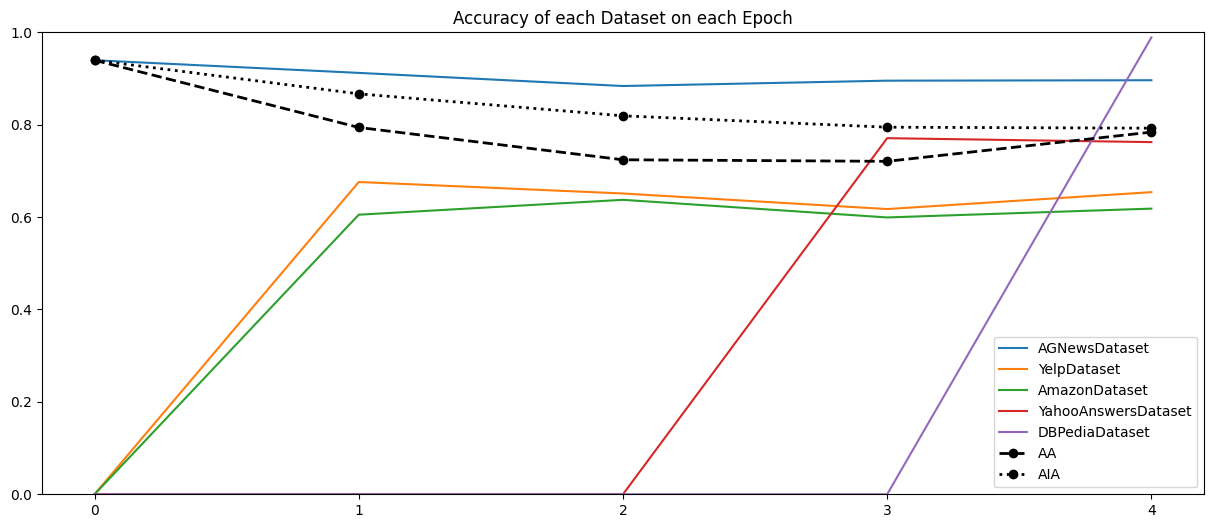

In [9]:
fig, ax =  plt.subplots(figsize=(15,6))
x = np.arange(len(acc)) # For each epoch
for i, key in enumerate(keys):
    ax.plot(x, [a[i] for a in acc], label=keys[i])
ax.plot(x, [a for a in aa], 'ko--', linewidth=2, label="AA")
ax.plot(x, [a for a in aia], 'ko:', linewidth=2, label="AIA")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Accuracy of each Dataset on each Epoch")
ax.set_ylim(0,1)
ax.legend()

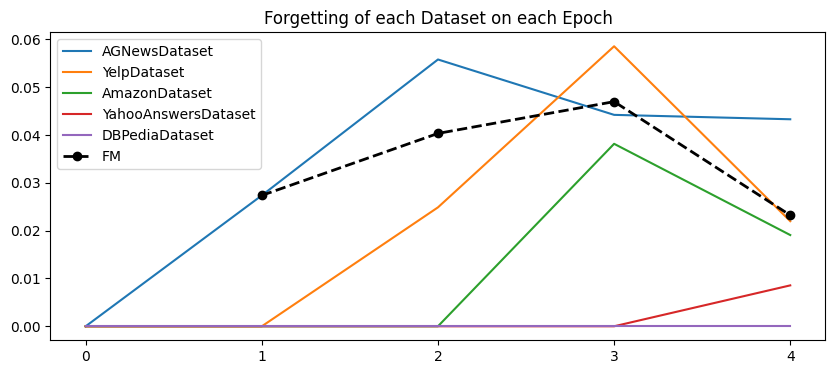

In [10]:
fig, ax =  plt.subplots(figsize=(10,4))
x = np.arange(len(forgetting)) # For each epoch
for i, key in enumerate(keys):
    ax.plot(x, [a[i] if i < len(a) else 0 for a in forgetting ], label=keys[i])
ax.plot(x, [a for a in fm], 'ko--', linewidth=2, label="FM")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Forgetting of each Dataset on each Epoch")
ax.legend()

# Average Adapt Score

In [11]:
find_path = f"update0" # For Update 0 to compare ! 
csv_names = [x for x in os.listdir(BASE_MODEL_PATH) if  re.search(f"id.*{find_path}.*results.*\.csv$", x)]
csv_paths = sorted([os.path.join(BASE_MODEL_PATH, csv_name) for csv_name in csv_names])
print(f"Using csv from {csv_paths}")

Using csv from ['/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id0-2023-03-12_20-12-03.549134_update0_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id1-2023-03-12_21-46-47.982146_update0_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id2-2023-03-12_23-19-49.310972_update0_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id3-2023-03-13_00-55-52.412861_update0_results.csv', '/data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id4-2023-03-13_02-29-39.653929_update0_results.csv']


In [12]:
n_acc = []
n_label_conf = []

print(f"Processing data in {csv_paths[-1]}")
n_label_dict, n_pred_dict, n_label_conf_dict = process_data(csv_paths[-1])

keys = tasks[order-1]
print(keys)

i=0
for key in keys:
    _acc, _prec, _rec, _f1 = models.utils.calculate_metrics(n_pred_dict[key], n_label_dict[key])
    n_acc[i].append(_acc) if i < len(n_acc) else n_acc.append([_acc])
    n_label_conf[i].append(n_label_conf_dict[key]) if i < len(n_label_conf) else n_label_conf.append([n_label_conf_dict[key]])
    
np.mean(n_acc)

Processing data in /data/model_runs/original_oml/aOML-order4-2023-03-13-no12/OML-order4-id4-2023-03-13_02-29-39.653929_update0_results.csv
['AGNewsDataset', 'YelpDataset', 'AmazonDataset', 'YahooAnswersDataset', 'DBPediaDataset']


0.7777105263157894

In [13]:
for acc_row in n_acc:
    print("\t".join(map(str, acc_row)))

0.8964473684210527	0.6406578947368421	0.6044736842105263	0.7581578947368421	0.9888157894736842


In [14]:
print(len(n_label_conf))
print(len(n_label_conf[-1]))
n_label_conf = np.array(n_label_conf[-1])
print(n_label_conf.shape)
print(f"Label Conf N \t Label Conf A")
print(f"{np.mean(n_label_conf)}\t{np.mean(a_label_conf)}")

1
5
(5, 7600)
Label Conf N 	 Label Conf A
0.7235590724231835	0.7299486287356051


In [15]:
an_label_conf = a_label_conf - n_label_conf
print("A-N")
np.mean(an_label_conf)

A-N


0.006389556312421566